<a href="https://colab.research.google.com/github/PeterPirog/tf-autoencoders/blob/main/01_mnist_VAE_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/examples/generative/vae/
Latent vector length =3

https://harvard-iacs.github.io/2019-CS109B/labs/lab10/VAE-solutions/

In [1]:
# Setup
import numpy as np
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras import layers

EPOCHS=1000  # for vae training
latent_dim = 2

In [2]:
# Create a sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [3]:
# Build the encoder

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
# Build the decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
# Define the VAE as a Model with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [6]:
callbacks_vae=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                factor=0.5,
                                                patience=3,
                                                min_lr=1e-5),
           tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5)]

In [7]:
# Train the VAE

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=EPOCHS, batch_size=128,callbacks=callbacks_vae)



11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/1000
547/547 [==============================] - 23s 19ms/step - loss: 260.8973 - reconstruction_loss: 204.8499 - kl_loss: 2.5273 - lr: 0.0010
Epoch 2/1000
547/547 [==============================] - 10s 19ms/step - loss: 168.2813 - reconstruction_loss: 161.6228 - kl_loss: 4.8039 - lr: 0.0010
Epoch 3/1000
547/547 [==============================] - 10s 19ms/step - loss: 163.0515 - reconstruction_loss: 156.6547 - kl_loss: 5.1404 - lr: 0.0010
Epoch 4/1000
547/547 [==============================] - 10s 19ms/step - loss: 159.8430 - reconstruction_loss: 154.1896 - kl_loss: 5.3241 - lr: 0.0010
Epoch 5/1000
547/547 [==============================] - 10s 19ms/step - loss: 157.9745 - reconstruction_loss: 152.5732 - kl_loss: 5.4640 - lr: 0.0010
Epoch 6/1000
547/547 [==============================] - 10s 19ms/step - loss: 157.2225 - reconstruction_loss: 151.3737 - kl_loss: 5.5535 - lr: 0.0010
Epoch 7/1000
547/547 [=============

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#Train data
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
z_mean_train, _, _ = vae.encoder.predict(x_train)

#Test data
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
z_mean_test, _, _ = vae.encoder.predict(x_test)

z_mean_train.shape



(60000, 2)

In [9]:
model=keras.models.Sequential()
model.add(keras.Input(shape=z_mean_train.shape[1:]))
model.add(keras.layers.Dense(30,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

In [10]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #val_loss
                                                factor=0.5,
                                                patience=3,
                                                min_lr=1e-5),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5),
           tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5',
                                              monitor='val_loss',
                                              save_best_only=True)]

In [11]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) # 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history=model.fit(x=z_mean_train,y=y_train,
          epochs=100,
          batch_size=32,
          validation_data=(z_mean_test,y_test),
          callbacks=callbacks) #

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 1.2055 - sparse_categorical_accuracy: 0.5864 - val_loss: 0.9195 - val_sparse_categorical_accuracy: 0.7040 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9002 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.7390 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8402 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.7885 - val_sparse_categorical_accuracy: 0.7560 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8085 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.7647 - val_sparse_categorical_accuracy: 0.7582 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7649 - lr: 0.0010
Epoch 6/100
1875/187

In [13]:
print(history.history.keys())

acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['sparse_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


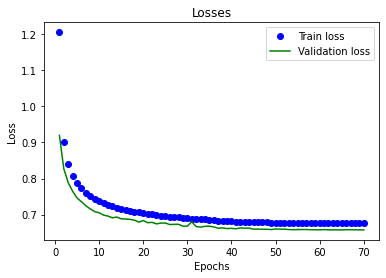

In [14]:
import matplotlib.pyplot as plt
plt.plot(epochs,loss,'bo',label='Train loss')
plt.plot(epochs,val_loss,'g',label='Validation loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();


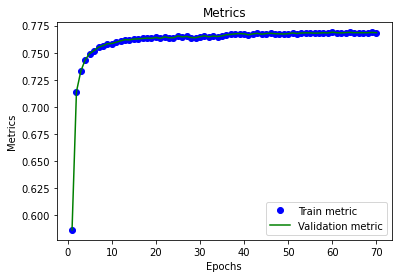

In [15]:
plt.plot(epochs,acc,'bo',label='Train metric')
plt.plot(epochs,val_acc,'g',label='Validation metric')
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend();